Training faces. It will take a few seconds. Please wait ...
labels_dict {1: '511144', 2: '518576', 3: '459495', 4: '490704', 5: '523522', 6: '522691', 7: '495494', 8: '491515', 9: '506122', 10: '489367', 11: '521825', 12: '555555', 13: '20240403', 14: '444444', 15: '524271', 16: '123456'}
Epoch 1/20


/Users/simranbirkaur/Python_Miniconda/miniconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 527ms/step - accuracy: 0.0420 - loss: 2.8091 - val_accuracy: 0.0385 - val_loss: 2.7719
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 629ms/step - accuracy: 0.2292 - loss: 2.5967 - val_accuracy: 0.1538 - val_loss: 2.5967
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 644ms/step - accuracy: 0.4760 - loss: 1.6094 - val_accuracy: 0.5000 - val_loss: 1.1120
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 622ms/step - accuracy: 0.7757 - loss: 0.7568 - val_accuracy: 0.6923 - val_loss: 0.7638
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 595ms/step - accuracy: 0.9067 - loss: 0.3708 - val_accuracy: 0.9231 - val_loss: 0.2739
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 582ms/step - accuracy: 0.9665 - loss: 0.2463 - val_accuracy: 0.5769 - val_loss: 1.4881
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 586ms/step - accuracy: 0.9383 - loss: 0.4100 - val_accuracy: 0.9231 - val_loss: 0.3664
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 534ms/step - accuracy: 0.9409 - loss: 0.2607 - val_accuracy: 0.8846 - val

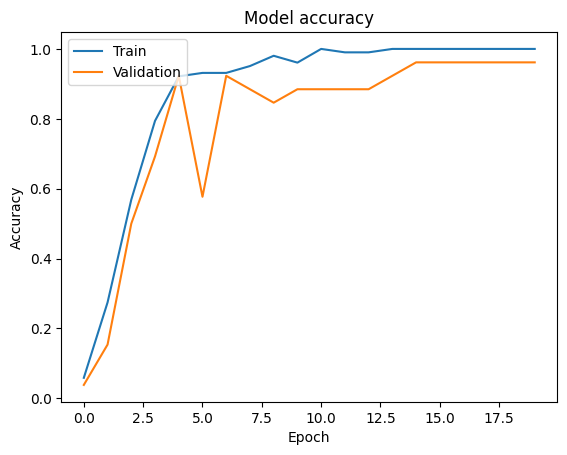

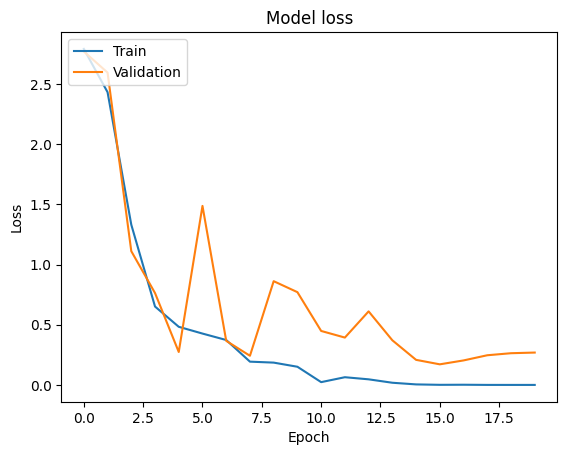

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
[11 10  6  9  3 10  2  1 15  7 15  6  4 14  5 11  8  2  5 12  0  0  8  0
 13 12  7 13  3  1  4 14]
accuracy 0.96875
Mean Squared Error (MSE): 2.5312
Root Mean Squared Error (RMSE): 1.5910
Mean Absolute Error (MAE): 0.2812
R^2 Score: 0.8809
Classification Report:
              precision    recall  f1-score   support

      511144       0.67      1.00      0.80         2
      518576       1.00      1.00      1.00         2
      459495       1.00      1.00      1.00         2
      490704       1.00      1.00      1.00         2
      523522       1.00      1.00      1.00         2
      522691       1.00      1.00      1.00         2
      495494       1.00      1.00      1.00         2
      491515       1.00      1.00      1.00         2
      506122       1.00      1.00      1.00         2
      489367       1.00      0.50      0.67         2
      521825       1.00      1.00      1.00         2
      555555       1.00      1.00      1.00      

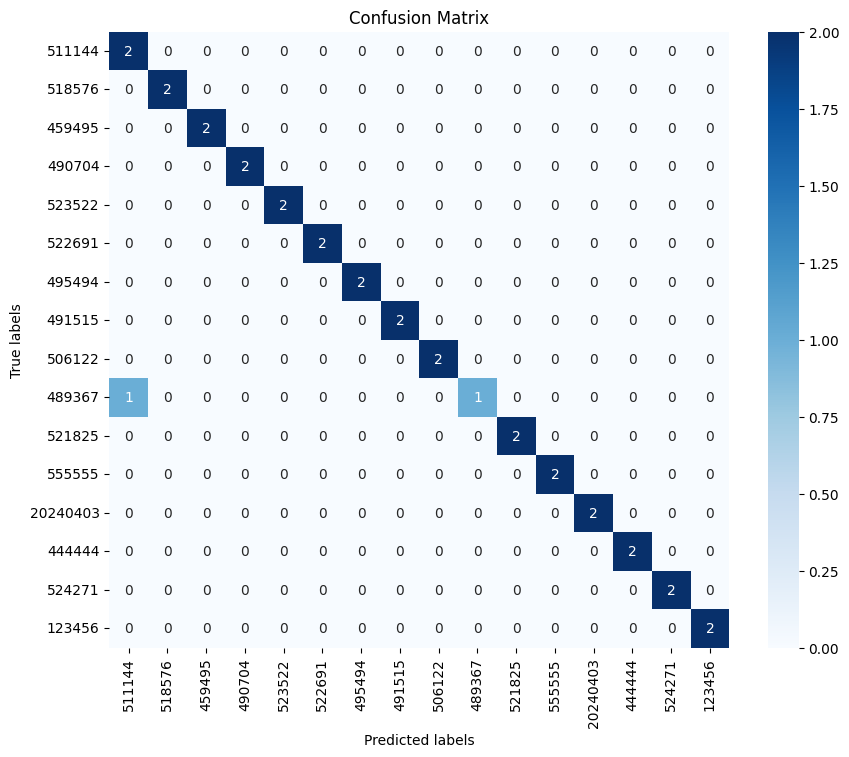

In [3]:
import numpy as np
import os
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

class FaceRecognitionCNN:
    def __init__(self, images_folder):
        self.images_folder = images_folder
        self.labels_dict = {}
        self.model = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.num_classes = None

    def _load_images_and_labels(self):
        images = []
        labels = []
        label = 0
        for root, dirs, files in os.walk(self.images_folder):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                    image_path = os.path.join(root, file)
                    img = cv2.imread(image_path)
                    img = cv2.resize(img, (250, 250))  # Resize image to 250x250
                    images.append(img)
                    labels.append(os.path.basename(root))  # Label is the folder name
            self.labels_dict[label] = os.path.basename(root)
            label += 1
        self.labels_dict.pop(0, None)
        print("labels_dict",self.labels_dict)
        return images, labels
    
    def _preprocess_data(self, images, labels):
        le = LabelEncoder()
        labels_encoded = le.fit_transform(labels)
        self.num_classes = len(le.classes_)
        images = np.array(images)
        labels_encoded = to_categorical(labels_encoded, self.num_classes)  # Convert labels to one-hot encoding       
        return images, labels_encoded
    
    def build_model(self):
        self.model = Sequential([
            tf.keras.layers.Rescaling(1./255), # Normalizing pixel values
            Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Conv2D(64, (2, 2), activation='relu'),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(256, activation='relu'),
            Dropout(0.2),
            Dense(self.num_classes, activation='softmax')
        ]) 
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    """def build_model(self):
        self.model = Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomZoom(0.1),
            tf.keras.layers.Rescaling(1./255), # Normalizaing pixel values
            Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Conv2D(64, (2, 2), activation='relu'),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(256, activation='relu'),
            Dropout(0.2),
            Dense(self.num_classes, activation='softmax')
        ]) 
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])"""

    def train(self, test_size=0.2, epochs=20, batch_size=10):

        print("Training faces. It will take a few seconds. Please wait ...")

        images, labels = self._load_images_and_labels()
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            images, labels, test_size=test_size, random_state=42, stratify=labels)
        self.X_train, self.y_train = self._preprocess_data(self.X_train, self.y_train)
        self.X_test, self.y_test = self._preprocess_data(self.X_test, self.y_test)
        self.build_model()
        history = self.model.fit(self.X_train, self.y_train, validation_split=0.2, shuffle=True, epochs=epochs, batch_size=10, verbose=1)
        self.plot_training_history(history)
        return history

    def plot_training_history(self, history):
        # Plot training & validation accuracy values
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()

        # Plot training & validation loss values
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()


    def test_model(self):
         # Test the model on the test set
        y_pred_prob = self.model.predict(self.X_test)
        y_pred = np.argmax(y_pred_prob, axis=1)  # Convert predicted probabilities to class labels
        print(y_pred)
        y_true = np.argmax(self.y_test, axis=1)

        accuracy = accuracy_score(y_true, y_pred)
        print("accuracy", accuracy)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        print(f"Mean Squared Error (MSE): {mse:.4f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
        print(f"R^2 Score: {r2:.4f}")
        print("=" * 50)
        print("Classification Report:")
        print(classification_report(y_true, y_pred, target_names=self.labels_dict.values()))
        self.plot_confusion_matrix(y_true, y_pred)

    def plot_confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=self.labels_dict.values(), yticklabels=self.labels_dict.values())
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()

# Example usage:
model = FaceRecognitionCNN(images_folder='/Users/simranbirkaur/Desktop/capstone_final/Face-Recognition-Based-Attendance-System/dataset/images')
history = model.train()
model.test_model()

